GoldenBraid Assembly of an ORF
===============
This notebook goes through the steps to turn an ORF contained in a vector into a PCR amplified linear DNA product that can be used in a GoldenBraid assembly. 
Here I use the GFP embedded in the pGLO plasmid (sequence taken from [pGLO on addgene](http://www.addgene.org/vector-database/6569/)).

You may want to compare the results to the primer3 output here to [primer3plus](http://www.bioinformatics.nl/cgi-bin/primer3plus/primer3plus.cgi), which has a specific "cloning" feature and if all is working should produce similar results.

In [803]:
# Setup cell
from __future__ import print_function, division

import re
import logging
import requests
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from StringIO import StringIO
from pprint import pprint
from IPython.display import display, Image, HTML, SVG

# Printing a few different ways
def uprint(astr): print(astr + "\n" + "-"*len(astr))
def show_html(astr): return display(HTML('{}'.format(astr)))
def show_svg(astr, w=1000, h=1000):
    SVG_HEAD = '''<?xml version="1.0" standalone="no"?><!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN" "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">'''
    SVG_START = '''<svg width="{w:}px" height="{h:}px" version="1.1" xmlns="http://www.w3.org/2000/svg" xmlns:xlink= "http://www.w3.org/1999/xlink">'''
    return display(SVG(SVG_HEAD + SVG_START.format(w=w, h=h) + astr + '</svg>'))

def table_print(rows, header=True):
    html = ["<table>"]
    html_row = "</td><td>".join(k for k in rows[0])
    html.append("<tr style='font-weight:{}'><td>{}</td></tr>".format('bold' if header is True else 'normal', html_row))
    for row in rows[1:]:
        html_row = "</td><td>".join(str(primer_design[k]) if k in primer_design else str(k) for k in row)
        html.append("<tr style='font-family:monospace;'><td>{:}</td></tr>".format(html_row))
    html.append("</table>")
    show_html(''.join(html))

# Plotting style
plt.rc("axes", titlesize=20, labelsize=15, linewidth=.25, edgecolor='#444444')
sns.set_context("notebook", font_scale=1.2, rc={})
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [757]:
# Utility functions. I could also use biopython here
rev_map = {"A":"T", "T":"A", "C":"G", "G":"C", "N":"N"}
def reverse_complement(dna_seq):
    return ''.join(rev_map[nt] for nt in dna_seq[::-1])
assert reverse_complement("TTTNCCCACGT") == "ACGTGGGNAAA"

Data input
=====
First we need to read in the DNA sequence we want to clone. 
This DNA sequence should be an ORF.
The data are stored in a Google spreadsheet, which must must be shared to anyone with the link for this to work.

Example: https://docs.google.com/spreadsheets/d/1Wyn7OiE12IgIGo0bds20ln-uR6QcpRQpEOFyXnI4rHA/edit#gid=0

Required fields:

    DNA sequence : AGTAGTGA
    sequence id  : GFP1
    source       : http://www.addgene.org/browse/sequence_vdb/6569/

In [567]:
# Get the data from the Google spreadsheet
gsheet_key = "1Wyn7OiE12IgIGo0bds20ln-uR6QcpRQpEOFyXnI4rHA"
csv = requests.get("https://docs.google.com/spreadsheets/d/{}/export?gid=0&format=csv".format(gsheet_key))

In [795]:
# Read in spreadsheet as CSV. pandas csv parser is better than the default Python one
required_fields = {"DNA sequence", "sequence id", "source"}
dnad = dict(pd.DataFrame.from_csv(StringIO(csv.text), index_col=False, header=-1).values)
assert set(dnad.keys()).issuperset(required_fields)

# Clean up the sequence if it has spaces or numbers
dnad["DNA sequence"] = re.sub("[0-9|\s]", "", dnad["DNA sequence"]).upper()
table_print([["Key", "Value"]] + dnad.items())

Key,Value
source,http://www.addgene.org/browse/sequence_vdb/6569/
sequence id,pGLO GFP ORF
DNA sequence,ATGGCTAGCAAAGGAGAAGAACTTTTCACTGGAGTTGTCCCAATTCTTGTTGAATTAGATGGTGATGTTAATGGGCACAAATTTTCTGTCAGTGGAGAGGGTGAAGGTGATGCTACATACGGAAAGCTTACCCTTAAATTTATTTGCACTACTGGAAAACTACCTGTTCCATGGCCAACACTTGTCACTACTTTCTCTTATGGTGTTCAATGCTTTTCCCGTTATCCGGATCATATGAAACGGCATGACTTTTTCAAGAGTGCCATGCCCGAAGGTTATGTACAGGAACGCACTATATCTTTCAAAGATGACGGGAACTACAAGACGCGTGCTGAAGTCAAGTTTGAAGGTGATACCCTTGTTAATCGTATCGAGTTAAAAGGTATTGATTTTAAAGAAGATGGAAACATTCTCGGACACAAACTCGAGTACAACTATAACTCACACAATGTATACATCACGGCAGACAAACAAAAGAATGGAATCAAAGCTAACTTCAAAATTCGCCACAACATTGAAGATGGATCCGTTCAACTAGCAGACCATTATCAACAAAATACTCCAATTGGCGATGGCCCTGTCCTTTTACCAGACAACCATTACCTGTCGACACAATCTGCCCTTTCGAAAGATCCCAACGAAAAGCGTGACCACATGGTCCTTCTTGAGTTTGTAACTGCTGCTGGGATTACACATGGCATGGATGAGCTCTACAAATAA


QC the DNA sequence, ensuring it's an ORF and that it does not include restriction enzyme recognition sites needed for the assembly.

**TODO Check if I need to remove the BstZI recognition site from the DNA sequence**

In [826]:
# Ensure that the input only includes ACGTN
assert all(nt in "ACGTN" for nt in dnad["DNA sequence"]), "Sequence has disallowed (non-ACGTN) nucleotides"

# Ensure that the input sequence is an ORF
if not (dnad["DNA sequence"].startswith("ATG") and
    any((dnad["DNA sequence"].endswith(stop) for stop in ["TAG", "TAA", "TGA"]))):
        logging.warn("DNA sequence is not an ORF: it does not start with ATG and end with TAG/TAA/TGA")

# Ensure that the restriction enzymes used in GoldenBraid are not in the sequence I am trying to insert
BsaI_seq = "GGTCTC" # https://www.neb.com/products/r0535-bsai
BsmBI_seq = "CGTCTC" # https://www.neb.com/products/r0580-bsmbi
BtgZI_seq = "GCGATG" # https://www.neb.com/products/r0703-btgzi
for re_name, rec_site in ("BsaI", BsaI_seq), ("BsmBI", BsmBI_seq), ("BtgZI", BtgZI_seq):
    found_res = dnad["DNA sequence"].find(rec_site) or dnad["DNA sequence"].find(reverse_complement(rec_site))
    if found_res != -1:
        logging.warn("Found recognition site {} in the input DNA sequence at position {}".format(re_name, found_res))

Primer3
====
[primer3-py](http://benpruitt.github.io/primer3-py/) is a Python-abstracted API for the popular Primer3 library. 

    The intention is to provide a simple and reliable interface for automated oligo analysis and design. Some of the most important issues in primer picking can be addressed only before using primer3. These are sequence quality (including making sure the sequence is not vector and not chimeric) and avoiding repetitive elements.

Primer3 comes with default global parameters that I start with (see below).
I then make the following changes to the global parameters:

- I tell Primer3 to amplify an entire segment (by setting PRIMER_TASK to 'pick_cloning_primers'. 
  With this parameter set, Primer3 only changes the length of the primer
- I reduce the optimal temperature to 55C and the maximum difference in Tm to 3C. 
  We will be adding more sequence at the next step of GoldenBraid, and that will increase the temperature. 
  By default, Primer3 has no maximum difference in Tm since the difference is accounted for in the total "penalty".
  Therefore, this parameter change may not be important.

The [primer3 manual](http://primer3.sourceforge.net/primer3_manual.htm) has details on all parameters.

In [789]:
# Instantiate primer3 with default parameters
import primer3
DEFAULT_global_primer3_args = {
    'PRIMER_OPT_SIZE': 20,
    'PRIMER_PICK_INTERNAL_OLIGO': 1,
    'PRIMER_INTERNAL_MAX_SELF_END': 8,
    
    'PRIMER_MIN_SIZE': 18,
    'PRIMER_MAX_SIZE': 25,
    
    'PRIMER_OPT_TM': 60.0,
    'PRIMER_MIN_TM': 57.0,
    'PRIMER_MAX_TM': 63.0,
    
    'PRIMER_MIN_GC': 20.0,
    'PRIMER_MAX_GC': 80.0,
    'PRIMER_MAX_POLY_X': 100,
    'PRIMER_INTERNAL_MAX_POLY_X': 100,
    'PRIMER_SALT_MONOVALENT': 50.0,
    'PRIMER_DNA_CONC': 50.0,
    'PRIMER_MAX_NS_ACCEPTED': 0,
    'PRIMER_MAX_SELF_ANY': 12,
    'PRIMER_MAX_SELF_END': 8,
    'PRIMER_PAIR_MAX_COMPL_ANY': 12,
    'PRIMER_PAIR_MAX_COMPL_END': 8,
    'PRIMER_PRODUCT_SIZE_RANGE': [[75,100],[100,125],[125,150], [150,175],[175,200],[200,225]],
}

Primer3 setup cell
------
Sequence-specific parameters for Primer3 are set up here:

In [792]:
# Force primer3 to include the entire ORF sequence (primer3-py is 0-indexed)
# Excluding an ATG that is provided by GoldenBraid. Do not skip the stop codon though.
skip_start = 3
skip_end = 0
seq_args = {
    'SEQUENCE_ID': dnad["sequence id"],
    'SEQUENCE_TEMPLATE': dnad["DNA sequence"],
    'SEQUENCE_INCLUDED_REGION': [0 + skip_start, len(dnad["DNA sequence"]) - (skip_start+skip_end)],
#    'PRIMER_TASK':'pick_cloning_primers' # important!!
}

# Force the primer product size to be the size of the ORF and decrease the temperature
# Add a constraint that the Tms cannot differ by more than a few degrees
global_primer3_args = dict(DEFAULT_global_primer3_args.items())
global_primer3_args.update({
    'PRIMER_OPT_TM': 55.0,
    'PRIMER_MIN_TM': 49.0,
    'PRIMER_MAX_TM': 60.0,
    'PRIMER_PAIR_MAX_DIFF_TM': 3.0,
    'PRIMER_TASK':'pick_cloning_primers',
    'PRIMER_PRODUCT_SIZE_RANGE': [[len(dnad["DNA sequence"]) - (skip_start+skip_end),
                                   len(dnad["DNA sequence"]) - (skip_start+skip_end)]],
#   'PRIMER_PICK_ANYWAY': True, # FIXFIX unclear if this does anything
})

def summarize_setup(seq_args, global_args):
    rows = [["Primer design summary"],
            ["Sequence length", "{:d}".format(len(dnad["DNA sequence"]))],
            ["Sequence GC content", "{:.3g}".format(sum(nt in "GC" for nt in dnad["DNA sequence"]) / len(dnad["DNA sequence"]) )],
            ["Primer size", "{:g}-{:g} nts".format(global_args["PRIMER_MIN_SIZE"], global_args["PRIMER_MAX_SIZE"])],
            ["Temperature range", "{:g}-({:g})-{:g} C".format(global_args["PRIMER_MIN_TM"], global_args["PRIMER_OPT_TM"], global_args["PRIMER_MAX_TM"])]
            ]
    table_print(rows)

#print(seq_args) # for debugging
summarize_setup(seq_args, global_primer3_args)

Run Primer3
------

In [754]:
def print_primer_info(primer_design):
    info = [["Primer", "Primer Sequence", "Length", "TM", "SELF_ANY_TH", "Penalty", "Explanation"]]
    for n in range(5):
        for f_r in ("LEFT", "RIGHT"):
            info.append(['{}_{}'.format(f_r, n), 
                         'PRIMER_{}_{}_SEQUENCE'.format(f_r, n), 
                         len(primer_design['PRIMER_{}_{}_SEQUENCE'.format(f_r, n)]),
                         'PRIMER_{}_{}_TM'.format(f_r, n), 
                         'PRIMER_{}_{}_SELF_ANY_TH'.format(f_r, n),
                         'PRIMER_PAIR_{}_PENALTY'.format(n),
                         'PRIMER_{}_EXPLAIN'.format(f_r)]
                       )
    table_print(info)

primer_design = primer3.bindings.designPrimers(seq_args, global_primer3_args)
print_primer_info(primer_design)

Primer,Primer Sequence,Length,TM,SELF_ANY_TH,Penalty,Explanation
LEFT_0,GCTAGCAAAGGAGAAGAACT,20,55.0785108402,10.6267437213,3.37130853783,"considered 8, ok 8"
RIGHT_0,TTATTTGTAGAGCTCATCCATG,22,53.7072023024,8.04723821196,3.37130853783,"considered 8, low tm 2, high tm 1, ok 5"
LEFT_1,GCTAGCAAAGGAGAAGAACT,20,55.0785108402,10.6267437213,4.80998902843,"considered 8, ok 8"
RIGHT_1,TTATTTGTAGAGCTCATCCATGC,23,56.7314781882,8.04723821196,4.80998902843,"considered 8, low tm 2, high tm 1, ok 5"
LEFT_2,GCTAGCAAAGGAGAAGAACTT,21,55.8894826353,10.6267437213,5.18228033291,"considered 8, ok 8"
RIGHT_2,TTATTTGTAGAGCTCATCCATG,22,53.7072023024,8.04723821196,5.18228033291,"considered 8, low tm 2, high tm 1, ok 5"
LEFT_3,GCTAGCAAAGGAGAAGAAC,19,53.4012569404,10.6267437213,5.89154075724,"considered 8, ok 8"
RIGHT_3,TTATTTGTAGAGCTCATCCATG,22,53.7072023024,8.04723821196,5.89154075724,"considered 8, low tm 2, high tm 1, ok 5"
LEFT_4,GCTAGCAAAGGAGAAGAAC,19,53.4012569404,10.6267437213,6.35741982516,"considered 8, ok 8"
RIGHT_4,TTATTTGTAGAGCTCATCCA,20,51.2413232345,0.860584685357,6.35741982516,"considered 8, low tm 2, high tm 1, ok 5"


In [766]:
def show_primer_posns(primer_design, primer_num=0):
    primer_types = ["PRIMER_LEFT_{}_SEQUENCE".format(primer_num), "PRIMER_RIGHT_{}_SEQUENCE".format(primer_num)]

    def _get_primer_posns():
        _primer_posns = {}
        for primer_type in primer_types:
            find_fwd_all = [m.start() for m in re.finditer(primer_design[primer_type], dnad["DNA sequence"])]
            find_fwd = find_fwd_all[0] if len(find_fwd_all)==1 else None
            find_rev_all = [m.start() for m in re.finditer(reverse_complement(primer_design[primer_type]), dnad["DNA sequence"])]
            find_rev = find_rev_all[0] if len(find_rev_all)==1 else None

            assert len(find_fwd_all) <= 1 and len(find_rev_all) <= 1
            assert find_fwd is not None or find_rev is not None

            p_posn = find_fwd if find_fwd is not None else find_rev
            _primer_posns[primer_type] = (p_posn, len(primer_design[primer_type]))

        return _primer_posns

    def _make_html_seq(_primer_posns):
        ann_dna = ['<div style="max-width:60em;word-break:break-all;font-family:monospace;">']
        col = dict(zip(_primer_posns.keys(), ["#dd4455", "#33dd33"]))
        
        for n, nt in enumerate(dnad["DNA sequence"]):
            colored = False
            for primer_type in primer_types:
                if colored is False and (n >= _primer_posns[primer_type][0] and 
                                         n < _primer_posns[primer_type][0] + _primer_posns[primer_type][1]):
                    ann_dna.append('<span style="color:{}">{}</span>'.format(col[primer_type], nt))
                    colored = True
            if colored is False:
                ann_dna.append(nt)
        ann_dna.append("</div>")
        
        show_html(" ".join('<span style="color:{}">{}</span>'.format(col[primer_type], primer_type) 
                           for primer_type in sorted(_primer_posns)))
        show_html(''.join(ann_dna))
    

    primer_posns = _get_primer_posns()
    _make_html_seq(primer_posns)
    
    return primer_posns

primer_posns = show_primer_posns(primer_design, primer_num=0)

In [780]:
uprint("Primer3 raw output")
pprint(primer_design)

Primer3 raw output
------------------
{'PRIMER_INTERNAL_0': (310L, 22L),
 'PRIMER_INTERNAL_0_GC_PERCENT': 59.09090909090909,
 'PRIMER_INTERNAL_0_HAIRPIN_TH': 38.08543199924429,
 'PRIMER_INTERNAL_0_PENALTY': 2.256510968137775,
 'PRIMER_INTERNAL_0_SELF_ANY_TH': 11.513897372687723,
 'PRIMER_INTERNAL_0_SELF_END_TH': 0.0,
 'PRIMER_INTERNAL_0_SEQUENCE': 'ACGGGAACTACAAGACGCGTGC',
 'PRIMER_INTERNAL_0_TM': 59.743489031862225,
 'PRIMER_INTERNAL_1': (310L, 22L),
 'PRIMER_INTERNAL_1_GC_PERCENT': 59.09090909090909,
 'PRIMER_INTERNAL_1_HAIRPIN_TH': 38.08543199924429,
 'PRIMER_INTERNAL_1_PENALTY': 2.256510968137775,
 'PRIMER_INTERNAL_1_SELF_ANY_TH': 11.513897372687723,
 'PRIMER_INTERNAL_1_SELF_END_TH': 0.0,
 'PRIMER_INTERNAL_1_SEQUENCE': 'ACGGGAACTACAAGACGCGTGC',
 'PRIMER_INTERNAL_1_TM': 59.743489031862225,
 'PRIMER_INTERNAL_2': (310L, 22L),
 'PRIMER_INTERNAL_2_GC_PERCENT': 59.09090909090909,
 'PRIMER_INTERNAL_2_HAIRPIN_TH': 38.08543199924429,
 'PRIMER_INTERNAL_2_PENALTY': 2.256510968137775,
 'PRIMER

We now have primers that should do a reasonable job at amplifying the entire ORF (excluding the first ATG).

We are ready to make these primers compatible with GoldenBraid. We will start with the primers that Primer3 thinks are the best for cloning the ORF (i.e., the primers with the lowest "penalty")

In [793]:
primer_num = 0 # top hit
partial_primers = {"L":primer_design["PRIMER_LEFT_{}_SEQUENCE".format(primer_num)],
                   "R":primer_design["PRIMER_RIGHT_{}_SEQUENCE".format(primer_num)]}

GoldenBraid (GB2.0)
====
If we want to use GoldenBraid then we need to add some more sequence onto the end of the primer.
We must include the appropriate GB2.0 4 nucleotide barcode, and a BsaI recognition site upstream, which will allow BsaI to cut at the barcode.
The eventual goal is to create an amplified linear PCR product that can be assembled into a destination vector (e.g., pDGBΩ1, pDGBΩ2, pDGBα1, or pDGBα2).

Domestication
---------
More typically, the part would also by properly "domesticated" by cloning it into an entry vector (pUPD) for reuse. 
That is a more complex process than just amplifying up GB-compatible linear DNA: 
- I would have to include a BsmBI recognition site for cloning into pUPD
- I would have to include a BtgZI recognition site as an alternative to BsaI
- I would also have to ensure there are no BsmBI or BtgZI recognition sites in the part (instead of just BsaI)
    
What are the three restriction enzymes for?
- BsmBI is used for cloning the part into the entry vector (pUPD)
- BsaI is used for cutting at the barcodes for GoldenBraid assembly
- BtgZI cuts at the same place as BsaI but is further upstream

The [primary article on GoldenBraid (GB2.0)](http://www.ncbi.nlm.nih.gov/pmc/articles/PMC3707536/) includes some instructions (images from this paper below.) GB2.0 is a refinement and simplification of the original GoldenBraid system. The images below are from GB2.0. This [iGEM project page](http://2014.igem.org/Team:Valencia_UPV/Project/modules/methodology/gb) and [JBEI page](https://j5.jbei.org/j5manual/pages/23.html) also have helpful descriptions. 

From the first image:
- barcode 1234 is AATG, which includes ATG Met codon
- barcode 5678 is GCTT, which includes no stop codon
    
The final PCR product should look like this, with the part (ORF) in frame with 234 (ATG), and a couple of extra spacer nucleotides on the ends:

    2bp       bcrd    brcd       2bp
     __       ____    ____       __
     GTGGTCTGG1234PART5678CGAGACCAC
       ______     ____     ______
        BsaI      ORF       BsaI

This image shows which barcodes to use for assembling different parts of the system ("TU", or transcriptional unit). Because we are incorporating an ORF, we start at barcode AATG and end at barcode GCTT.

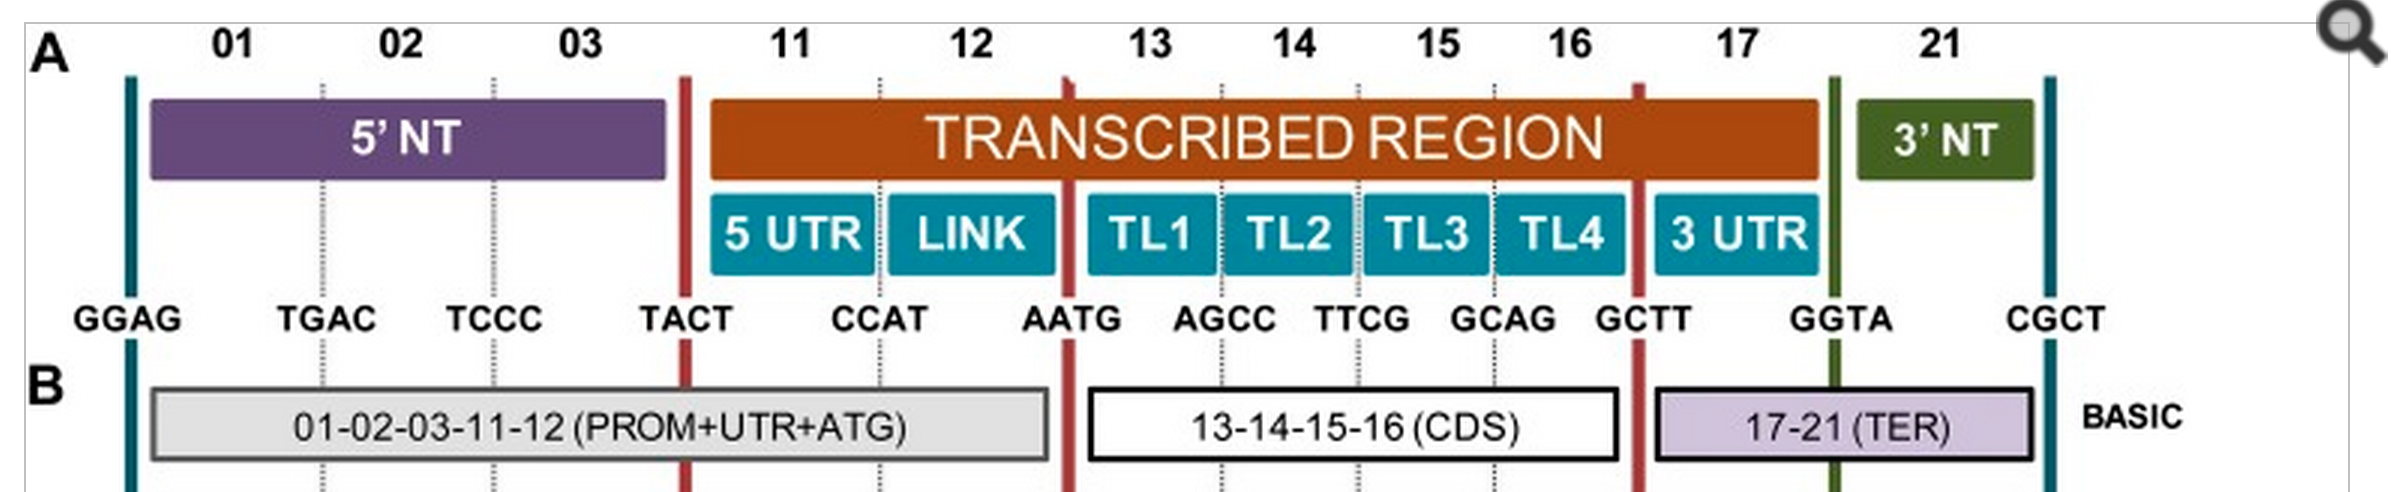

In [763]:
Image("goldenbraid_instructions1.png")

This image shows a GB2.0 part being domesticated. 

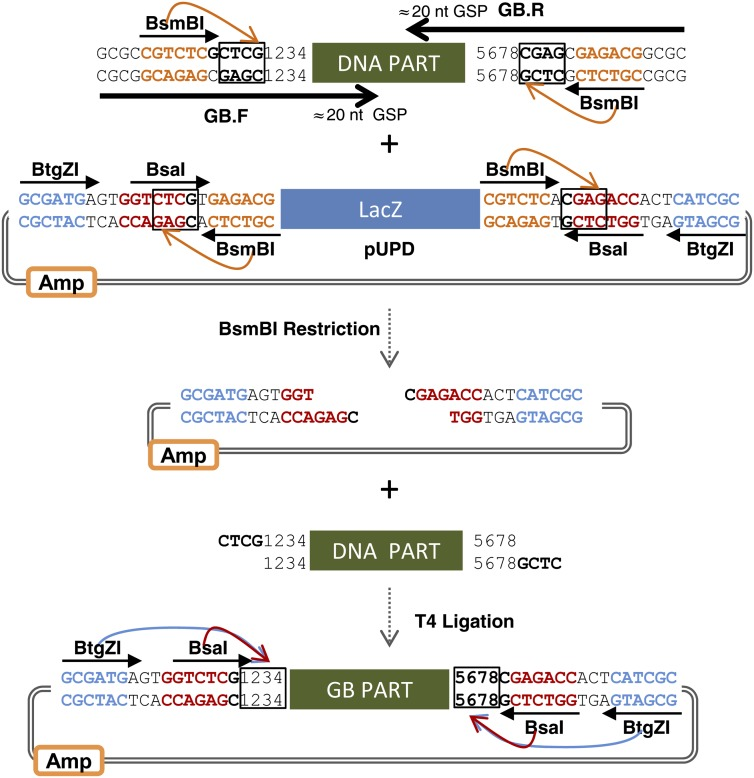

In [762]:
Image("goldenbraid_instructions2.jpg")

Golden Gate is very similar to GoldenBraid (MoClo is also similar). 
[JBEI](https://j5.jbei.org/j5manual/pages/23.html) has some nice documentation on these three systems, including a diagram of how the PCR product gets incorporated into the destination vector (below). The IIS restriction enzyme makes the process directional (i.e. the final product has no BsaI recognition sites).

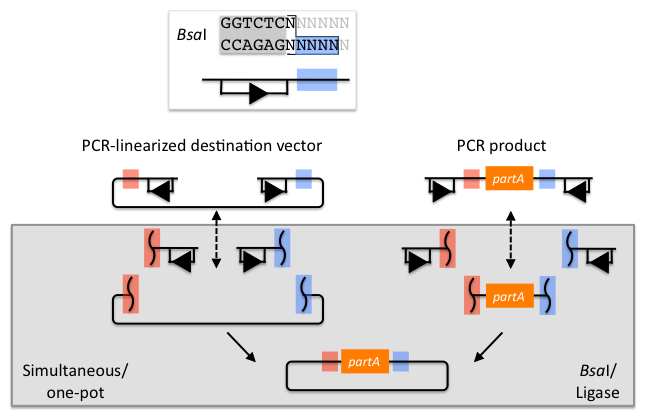

In [673]:
Image("goldengate_instructions1.png")

Here we add the BsaI site and the two 4-base barcodes/overhangs (13 nucleotides in total) to the primers that amplify the ORF.
We also include two extra bases on the end (GT, arbitrarily) so that BsaI has something to grab onto.

Since BtgZI is only really necessary if we are domesticating into the entry vector for reuse, **and** since the GFP sequence actually includes a BtgZI site, it is better not to include the BtgZI sequence.

In [828]:
#          BsaI  1234
#         ______ ____
seqL = "GTGGTCTCGAATG"

#          BsaI  8765
#         ______ ____
seqR = "GTGGTCTCGAAGC"

gb_primers = {"L":seqL + partial_primers["L"],
              "R":seqR + partial_primers["R"]}

QC of GB primers
--
Check the length of the primers and the new melting temperature after adding the BsaI/barcode sequence.
If it's too high, then PCR will not work efficiently.

Primer3 function:

    primer3.bindings.calcTm(seq, mv_conc=50, dv_conc=0, dntp_conc=0.8, dna_conc=50, max_nn_length=60, 
                            tm_method='santalucia', salt_corrections_method='santalucia')

In [822]:
MAX_GB_PR_TM = 70
MAX_GB_PR_LEN = 60

tms = {f_r:primer3.bindings.calcTm(gb_primers[f_r]) for f_r in "LR"}

if any(tm>MAX_GB_PR_TM for f_r,tm in tms.items()):
    logging.warn("GB primers Tm may be too high (>{}): {}".format(MAX_GB_PR_TM, tms.items()))

if any(len(primer)>MAX_GB_PR_LEN for f_r,primer in gb_primers.items()):
    logging.warn("GB primers may be too long (>{}): {}".format(MAX_GB_PR_LEN, gb_primers.items()))

uprint("Summary of GB primers")
for f_r in "LR":
    print("Full {} primer:\tLength {}\tTm {:.4g}C\t{}".format(f_r, 
        len(gb_primers[f_r]), primer3.bindings.calcTm(gb_primers[f_r]), gb_primers[f_r]))

Summary of GB primers
---------------------
Full L primer:	Length 33	Tm 63.01C	GTGGTCTCGAATGGCTAGCAAAGGAGAAGAACT
Full R primer:	Length 35	Tm 61.94C	GTGGTCTCGAAGCTTATTTGTAGAGCTCATCCATG


Full Domestication Protocol from GBCloning
====================

Give the ORF sequence from the Google spreadsheet to the [domestication tool on the GoldenBraid homepage](https://gbcloning.upv.es/do/domestication/)
and it returns the following protocol:

    Category:CDS (B3-B4-B5)
    Prefix:AATG
    Suffix:GCTT

    Domestication Protocol

    Perform a PCR amplification for each patch with the given pair of oligos by using your DNA Polymerase manufacturer's protocol:

        PCR product: GCGCCGTCTCGCTCGAATGGCTAGCAAAGGAGAAGAACTTTTCACTGGAGTTGTCCCAATTCTTGTTGAATTAGATGGTGATGTTAATGGGCACAAATTTTCTGTCAGTGGAGAGGGTGAAGGTGATGCTACATACGGAAAGCTTACCCTTAAATTTATTTGCACTACTGGAAAACTACCTGTTCCATGGCCAACACTTGTCACTACTTTCTCTTATGGTGTTCAATGCTTTTCCCGTTATCCGGATCATATGAAACGGCATGACTTTTTCAAGAGTGCCATGCCCGAAGGTTATGTACAGGAACGCACTATATCTTTCAAAGATGACGGGAACTACAAGACGCGTGCTGAAGTCAAGTTTGAAGGTGATACCCTTGTTAATCGTATCGAGTTAAAAGGTATTGATTTTAAAGAAGATGGAAACATTCTCGGACACAAACTCGAGTACAACTATAACTCACACAATGTATACATCACGGCAGACAAACAAAAGAATGGAATCAAAGCTAACTTCAAAATTCGCCACAACATTGAAGATGGATCCGTTCAACTAGCAGACCATTATCAACAAAATACTCCAATTGGCGACGCGAGACGGCGC
        Oligo forward: GCGCCGTCTCGCTCGAATGGCTAGCAAAGGAGAAGAA
        Oligo reverse: GCGCCGTCTCGCGTCGCCAATTGGAGTATTTT

        PCR product: GCGCCGTCTCGGACGGCCCTGTCCTTTTACCAGACAACCATTACCTGTCGACACAATCTGCCCTTTCGAAAGATCCCAACGAAAAGCGTGACCACATGGTCCTTCTTGAGTTTGTAACTGCTGCTGGGATTACACATGGCATGGATGAGCTCTACAAATAAGCTTCGAGCGAGACGGCGC
        Oligo forward: GCGCCGTCTCGGACGGCCCTGTCCTTTTACC
        Oligo reverse: GCGCCGTCTCGCTCGAAGCTTATTTGTAGAGCTCATCCATGC

    Once you have all your patches the domestication reaction should be performed as follows:
    40 ng of each patch
    75 ng of pUPD
    5-10u BsmBI
    3u T4 Ligase
    1 microlitre Ligase Buffer

    Final volume: 10 microlitres

    We use Promega T4 DNA ligase(M180B) and fermentas BsmBI/Esp3I (ER0451). We haven't tried other enzymes suppliers but they will problably work as well.

    Set your reaction in a thermocycler: 25 cycles x (37C 2', 16C 5').
    One microlitre of the reaction is enough to be transform E.coli electrocompetent cells. Positive clones are selected in Ampicillin (50 microgram ml-1), IPTG (0.5mM) and Xgal (40 microgram ml-1) plates. You will distinguish between colonies carrying intact vectors (blue) and those transformed with your construction (white).


Interpreting the protocol
---------------------
The GB2.0 domestication primers add a BsmBI site, as we expect for inserting into pUPD. Note how the first 1234 is AATG and the last 5678 is GCTT. I also note that the PCR excludes the first ATG in the ORF and includes the stop codon.

        BsmBI      1234
        ______     ____
    GCGCCGTCTCGCTCGAATGGCTAGCAAAGGAGAAGAA
    ____       ____    __________________
    GCGC       cut     ORF (excluding ATG)
    
        BsmBI      8765 
        ______     ____  
    GCGCCGTCTCGCGTCGCCAATTGGAGTATTTT
    ____       ____    _____________
    GCGC       cut     ORF(~posn 585)

        BsmBI      1234 
        ______     ____
    GCGCCGTCTCGGACGGCCCTGTCCTTTTACC
    ____       ____    ____________
    GCGC       cut     ORF(~posn 585)
    
        BsmBI      8765
        ______     ____
    GCGCCGTCTCGCTCGAAGCTTATTTGTAGAGCTCATCCATGC
    ____       ____    _______________________
    GCGC       cut     ORF (end including stop)
    
Why does the domestication require the use of two separate PCR reactions?
Here I compare the first PCR product to the full ORF sequence.
We can see that the reason the assembly is done in two steps is because of a BtgZI restriction site 
at position 585 in the ORF.

                                                         BtgZI (position 585)
                                                         ______
    PCR             CAACTAGCAGACCATTATCAACAAAATACTCCAATTGGCGATGCGAGACGGCGC
    ORF 548 nts ... CAACTAGCAGACCATTATCAACAAAATACTCCAATTGGCGATGGCCCTGTCCTTTTACCAGACAACCATTACC
